In [30]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from nltk.tokenize import word_tokenize
import string
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
# Download and load the Shakespeare text data
filepath = tf.keras.utils.get_file('shakespeare.txt',
                                    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### EDA (Exploratory Data Analysis)

In [32]:
text = open(filepath, 'rb').read().decode(encoding='utf-8')

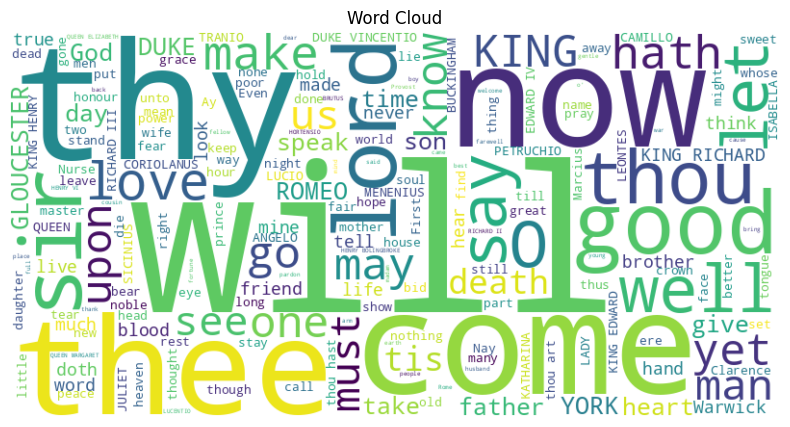

In [33]:
# Generate and save Word Cloud of the entire text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud')
plt.savefig("word_cloud.png")

In [74]:
# Count characters and unique characters
characters = sorted(set(text))
char_count = len(text)
unique_chars = len(characters)

print("Total Characters:", char_count)
print("Unique Characters:", unique_chars)


Total Characters: 1053696
Unique Characters: 27


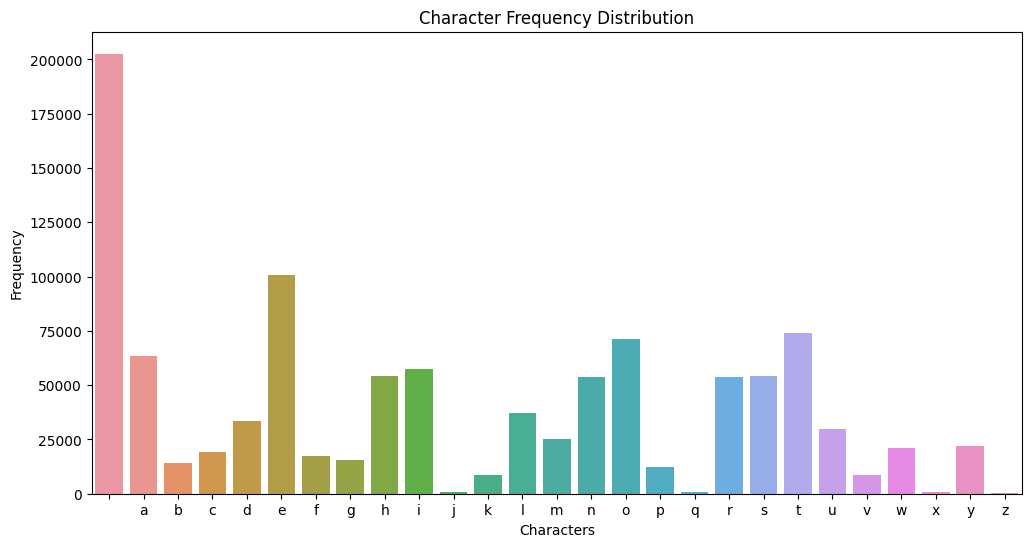

In [75]:
# Count character occurrences
character_counts = {char: text.count(char) for char in characters}

# Plot character frequency distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(character_counts.keys()), y=list(character_counts.values()))
plt.title('Character Frequency Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()


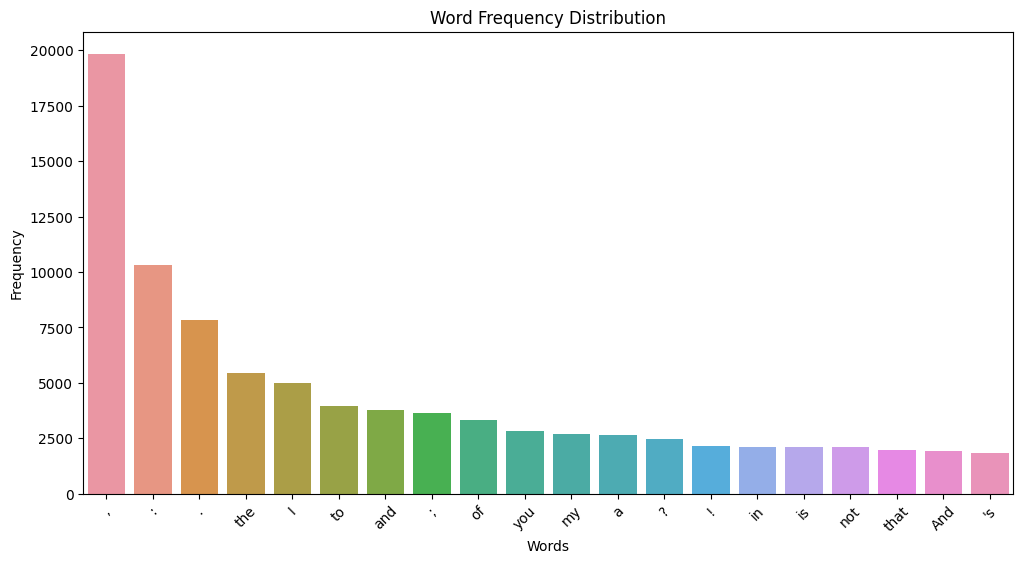

In [34]:
# Tokenize text
tokens = word_tokenize(text)

# Count word occurrences
word_counts = Counter(tokens)

# Plot word frequency distribution (top N words)
N = 20
most_common_words = word_counts.most_common(N)
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title('Word Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


### PREPROCESSING


In [35]:
#Lowercasing:
text = text.lower()


In [36]:
#Remove Punctuation
import string
text = text.translate(str.maketrans('', '', string.punctuation))


In [37]:
#Tokenization
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)


In [38]:
#Remove Numbers
text = ''.join([char for char in text if not char.isdigit()])


In [39]:
#Stopword Removal
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word not in stop_words]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
#Stemming or Lemmatization
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in tokens]


In [41]:
#Removing Extra Whitespace
text = ' '.join(text.split())


In [42]:
#Spell Correction
!pip install pyspellchecker

from spellchecker import SpellChecker
spell = SpellChecker()
corrected_tokens = [spell.correction(word) for word in tokens]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.7 MB/s eta 0:00:00


In [45]:
# Create dictionaries for character to index and index to character mapping
char_to_index = dict((c, i) for i, c in enumerate(characters))
index_to_char = dict((i, c) for i, c in enumerate(characters))

In [46]:
# Hyperparameters
SEQ_LENGTH = 40  # Length of input sequences
STEP_SIZE = 3   # Step size for creating sequences


In [47]:
# Preprocessing - Create sequences and labels
sentences = []  # Input sequences
next_char = []  # Corresponding next characters


In [49]:
for i in range(0, len(text) - SEQ_LENGTH, STEP_SIZE):
    sentences.append(text[i: i + SEQ_LENGTH])
    next_char.append(text[i + SEQ_LENGTH])

In [50]:
# Create one-hot encoded input data and labels
x = np.zeros((len(sentences), SEQ_LENGTH, len(characters)), dtype=np.bool)
y = np.zeros((len(sentences), len(characters)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_index[char]] = 1
    y[i, char_to_index[next_char[i]]] = 1

<ipython-input-50-64f23fb78983>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), SEQ_LENGTH, len(characters)), dtype=np.bool)
<ipython-input-50-64f23fb78983>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(characters)), dtype=np.bool)


### MODELING

In [51]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(SEQ_LENGTH, len(characters))))
model.add(Dense(len(characters)))
model.add(Activation('softmax'))

In [52]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

In [54]:
# Model training
history = model.fit(x, y, batch_size=200, epochs=3)


Epoch 1/3
1757/1757 [==============================] - 258s 146ms/step - loss: 2.2508
Epoch 2/3
1757/1757 [==============================] - 255s 145ms/step - loss: 1.9658
Epoch 3/3
1757/1757 [==============================] - 251s 143ms/step - loss: 1.8499


In [60]:
# Generate text using the trained model
def generate_text(length, temperature):
    start_index = random.randint(0, len(text) - SEQ_LENGTH - 1)
    generated = ''
    sentence = text[start_index: start_index + SEQ_LENGTH]
    generated += sentence

    for i in range(length):
        x_predictions = np.zeros((1, SEQ_LENGTH, len(characters)))
        for t, char in enumerate(sentence):
            x_predictions[0, t, char_to_index[char]] = 1

        predictions = model.predict(x_predictions, verbose=0)[0]
        next_index = sample(predictions, temperature)
        next_character = index_to_char[next_index]

        generated += next_character
        sentence = sentence[1:] + next_character

    return generated

In [62]:
# Sampling function for text generation
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

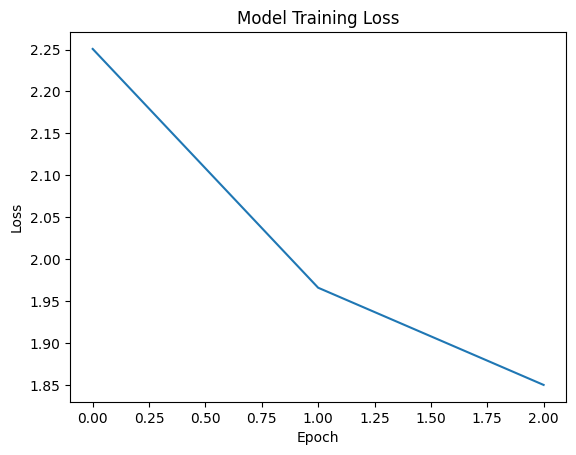

In [63]:
# Generate text with various temperatures
results = {}
temperatures = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
for temp in temperatures:
    generated_text = generate_text(300, temp)
    results[f"Temperature {temp}"] = generated_text

# Visualize training loss over epochs
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


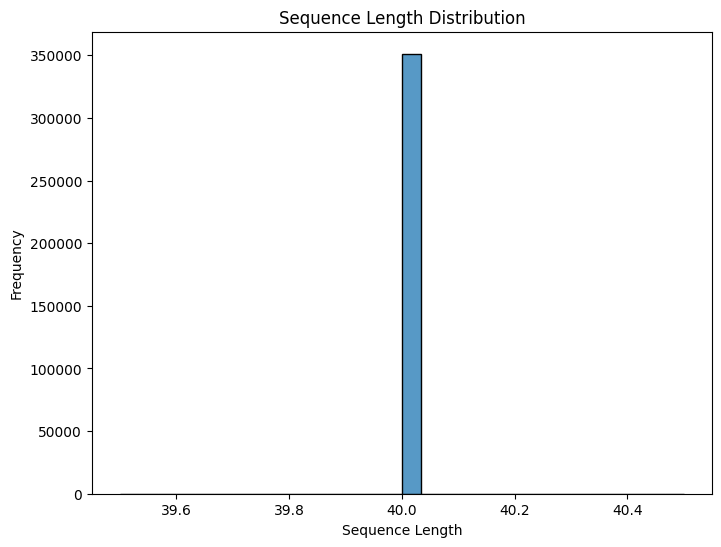

In [64]:
sequence_lengths = [len(sentence) for sentence in sentences]

# Plot sequence length distribution
plt.figure(figsize=(8, 6))
sns.histplot(sequence_lengths, bins=30)
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


### RESULTS

In [72]:
# Generate text with various temperatures
results = {}
temperatures = [0.2, 0.6, 0.3, 0.5]
for temp in temperatures:
    generated_text = generate_text(100, temp)
    results[f"Temperature {temp}"] = generated_text


with open("text_generation_report.md", "w") as report:
    report.write("# Text Generation Results\n\n")

    for temp, text_result in results.items():
        report.write(f"## {temp}\n\n")
        report.write("<div style='background-color: #f4f4f4; padding: 10px; border-radius: 5px;'>\n")
        report.write(f"<p style='font-size: 16px; line-height: 1.5;'>{text_result}</p>\n")
        report.write("</div>\n\n")




In [73]:
from IPython.display import display, Markdown

# Load the Markdown content from the file
with open("text_generation_report.md", "r") as report_file:
    markdown_content = report_file.read()

# Display the Markdown content as HTML
display(Markdown(markdown_content))


# Text Generation Results

## Temperature 0.2

<div style='background-color: #f4f4f4; padding: 10px; border-radius: 5px;'>
<p style='font-size: 16px; line-height: 1.5;'> infect her leontes why he that wears he shall he hat i have stark the the stark the sare hath he hat he he stare the the the stark the sir </p>
</div>

## Temperature 0.6

<div style='background-color: #f4f4f4; padding: 10px; border-radius: 5px;'>
<p style='font-size: 16px; line-height: 1.5;'>abour is but lost for warwick is a subtle this but his a sare tot mare the enere that with cleat ent as mo the stinn hath has tian the yill </p>
</div>

## Temperature 0.3

<div style='background-color: #f4f4f4; padding: 10px; border-radius: 5px;'>
<p style='font-size: 16px; line-height: 1.5;'>ill plead for you as for my patron stand be the ear the sare that the count that the can the surt the the sead he mare the sool stay the the</p>
</div>

## Temperature 0.5

<div style='background-color: #f4f4f4; padding: 10px; border-radius: 5px;'>
<p style='font-size: 16px; line-height: 1.5;'>ias but soft company is coming here good the the the stake hear the thin she hare here the this have the neare our he duke the had he his on</p>
</div>

